<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [46]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

redpath = "/Users/grudnick/Work/Teaching/Classes/Astro_596/Fall_2019/Observing_project/Data/Reduced/20191104/"

<h3> Find the stars in your image</h3>

In [31]:
#filename should be the name of the file (without path) that has the correct 
#WCS header, e.g. one output by astrometry.net. 
def read_one_image(filename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(hdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [39]:
img_ngc7296_V, hdr, imgwcs, imgfile_ngc7296_V = read_one_image('wngc7276_V_comb.fits',redpath)

Reading /Users/grudnick/Work/Teaching/Classes/Astro_596/Fall_2019/Observing_project/Data/Reduced/20191104/wngc7276_V_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [40]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [41]:
#***********
bkg = get_sky_background(img_ngc7296_V, verbose=True)
#***********
img_ngc7296_V_nosky = img_ngc7296_V - bkg.background

Sky background median = 2.190, rms = 0.061 electrons.


In [47]:
def qa_background(img,img_nosky):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

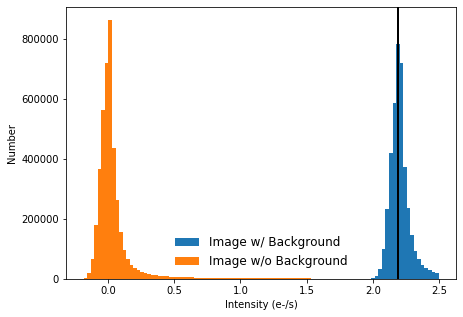

In [48]:
#***********
qa_background(img_ngc7296_V, img_ngc7296_V_nosky)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [49]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [50]:
#***********
srcs = find_stars(img_ngc7296_V_nosky, imgfile_ngc7296_V, sigma=bkg.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs

Read 2290 stars from /Users/grudnick/Work/Teaching/Classes/Astro_596/Fall_2019/Observing_project/Data/Reduced/20191104/stars-wngc7276_V_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1023,960.5819025640336,936.7008421879661,0.38795082296512595,0.20332742820068261,0.24528511321087365,25,0.0,1158.4108832906288,2342.5907288546446,-8.424241050423413
2,1325.5270196460192,1.9651091570790755,0.2445608640601416,0.2599328480956012,-0.1842068119177257,25,0.0,1155.8588439287562,2288.792314510621,-8.399015966227514
1820,133.4175527913585,1643.1952615693606,0.4265310171349403,0.23262266406215712,-0.24733995857211488,25,0.0,1161.9728964699716,2092.805260735559,-8.301822045855406
1549,1561.7471580894855,1408.2291103902173,0.3900824348408227,-0.043128788705076415,-0.15886428136465847,25,0.0,1156.9120671297148,2046.347959735462,-8.277448707047865
1635,1837.6372647805883,1485.0359976685731,0.42961589698503877,-0.07783382003132999,-0.22347806399873146,25,0.0,1072.7402498646145,2010.7829847792502,-8.258413003942628
1883,901.0163011075624,1705.593816794147,0.3407653976221992,0.013515025783855683,-0.25523430312009515,25,0.0,1158.1382559121967,1805.6872004902425,-8.141606298959832
416,972.548176663112,376.76554132245377,0.3981295107128885,0.06435465654391541,-0.10814045179307555,25,0.0,1056.913125749724,1575.799457101368,-7.993752366297477
1632,965.9138655865881,1484.5123170822883,0.4215239716447243,0.052114675352738955,-0.12816724390155565,25,0.0,932.6436816967833,1513.5702049050974,-7.9500064248036075
1466,120.89085288898386,1325.6985526981962,0.47719422425767594,0.08684876532469409,-0.2039629775860987,25,0.0,1111.9912094332503,1479.3202157508135,-7.9251554804301785


<h3> Find the positions and RAs and Decs of the stars from Webda</h3>

We will need to read in magnitudes from Webda and figure out which stars the belong to in our image.  Webda has separate tables for coordinates and magnitude they don't have the same number of objects and some tables have multiple entries for each object.  So first we need to combine the webda tables, and then we can combine them with our tables.

<h4>Save the Webda info to text files</h4>
You will need to find your cluster and go to the "Coordinates J2000" link under the "Available Data" link.  You should copy the contents of this page to an empty text file using your editor of choice.  The format should be that the first line starts with "#" (without the quotes) followed by the data.  Give it a name like "radec_ngc7296.txt" and put it either in your redpath or another directory.

Do the same for the UBVCCD info but call it something like "ubvccd_ngc7296.txt". Also, make sure that there isn't an extra column name.  For example, some of the files have no U-B data but have a "U-B" column name.  Delete that column name if it exists.  

The first few lines of my radec file look like this:
<li>#  No    Ref   RA(2000)      Dec(2000)
<li> 0001   385  22 28 05.35   +52 20 25.00
<li> 0001   475  22 28 05.50   +52 20 22.40
<li> 0002   385  22 28 01.53   +52 20 07.11

Note that the first entry is a duplicate, with two locations from two different literature sources.  The following code will deal with that.

This code reads in your two files and collates them into a single table

In [51]:
from astropy.io import ascii
filepath = '/Users/grudnick/Work/Teaching/Classes/Astro_596/Fall_2019/Observing_project/Cluster_files/NGC7926/'
def webda_read(radecfile, magfile, filepath):
    radecpath = os.path.join('{}'.format(filepath), radecfile)
    magpath = os.path.join('{}'.format(filepath), magfile)
    
    mags = ascii.read(magpath)
    
    #convert the webda RA-DEC format into another

<h3> Use stars from Pan-STARRS</h3>

We will be using stars

In [ ]:
def get_panstarrs_catalog(imgwcs, imgfile, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    
    #rmag = allcat['rMeanPSFMag']
    #good = np.isfinite(rmag) * rmag < rfaint
    #cat = allcat[good]
    #print('Keeping {}/{} Pan-STARRS sources.'.format(len(cat), len(allcat)))
    return allcat